In [1]:
%matplotlib inline
import networkx as nx

# Capitulo 3

Contenido:

1. [Buscar centros](#Buscar-centros)
2. [Distribuciones de centralidad](#Distribuciones de centralidad)
3. [Probando robustez](#Prueba-robustez)


## 1. Buscar centros

A menudo, cuando miramos una red, queremos encontrar los nodos más "importantes", para alguna definición de importante. La medida más básica de centralidad es el *grado*, o número de enlaces adjuntos a un nodo.

Veamos el gráfico de correo electrónico ejecutivo de Enron:

/tmp/ipykernel_9532/3165687546.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Graph with 143 nodes and 623 edges


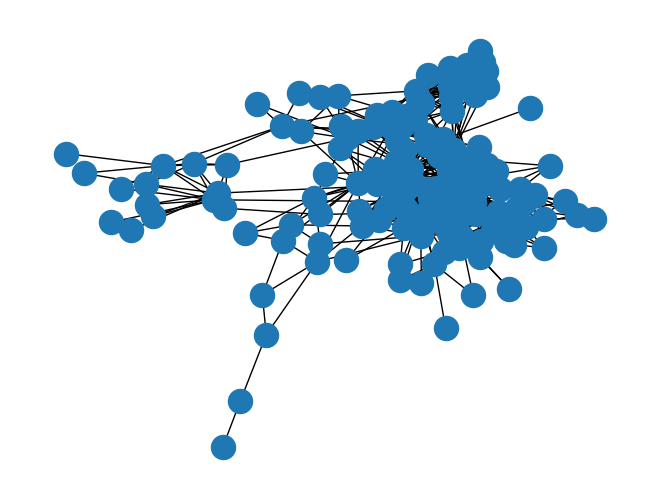

In [3]:
G = nx.read_edgelist('./datasets/ia-enron-only/ia-enron-only.edges', nodetype=int)
print(nx.info(G))
nx.draw(G)

### Advertencia: por defecto, `nx.read_edgelist` asume que los nombres de los nodos son cadenas

Las listas de bordes son un formato de texto sin formato simple para almacenar gráficos. Dado que este formato de archivo simple no contiene información sobre el tipo de datos, se supone que todos los nombres de los nodos son cadenas de forma predeterminada. Cuando los nombres de los nodos son números enteros, como en este ejemplo, debemos especificar el argumento de la palabra clave `nodetype=int` para evitar confusiones con los nombres de los nodos.


### Aparte: la función `max`

Hagamos uso de la función `max` incorporada de Python para encontrar el nodo con el grado más alto.

Primero, recordemos lo que hace la función `max`. En su forma más básica, la función `max` devuelve el elemento "más grande" en una secuencia:

In [4]:
max([1,2,3,4,5])

5

Pero el elemento "más grande" no siempre es obvio:

In [5]:
max(['apple', 'grape', 'carrot'])

'grape'

¿Por qué `grape` es mayor que las otras opciones? Porque el orden predeterminado para las cadenas es el orden lexicográfico (básicamente alfabético). Si no queremos este orden predeterminado, podemos especificar una función *clave*, que le indica a Python cómo comparar los elementos:

In [6]:
max(['apple', 'grape', 'carrot'], key=len)

'carrot'


Ahora `carrot` es el elemento más grande, porque estamos comparando los elementos por su longitud.

### Encontrar el nodo con grado máximo

Podemos aplicar la función `max` para obtener el nodo máximo según algún criterio. En nuestro caso, queremos comparar los nodos por su grado:

In [7]:
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

105

In [8]:
G.degree(highest_degree_node)

42

Entonces sabemos que el nodo `105` tiene 42 aristas conectadas a él. Veamos ese cálculo un poco más de cerca:

```python
max(G.nodos, clave=G.grado)
```

Le estamos diciendo a la función `max` que queremos el elemento de `G.nodes` que nos da el valor más alto cuando se pasa a la función *key* `G.degree`.

Esta construcción funciona porque `G.degree` es una función. Algunas otras medidas de centralidad, como la intermediación, generan todos los valores de centralidad de los nodos a la vez y devuelven un `dict`. En este caso, necesitamos un paso adicional:

In [9]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
highest_betweenness_node

105

In [10]:
betweenness[highest_betweenness_node]

0.19400604344556296

Tenga en cuenta que lo siguiente arrojará un error:

In [11]:
max(G.nodes, key=betweenness)

TypeError: 'dict' object is not callable


Esto se debe a que necesitamos proporcionar una función al argumento `key`, pero `betweenness` es un dict. Para evitar esto, usamos el método `get` de dict.

## 2. Distribuciones de centralidad

Hemos encontrado el nodo más central de la red, pero a menudo queremos resumir información sobre la centralidad de todos los nodos. Por ejemplo, además del grado máximo mínimo, a menudo queremos el grado medio y mediano en una red.

El primer paso para resumir esta información es obtener una secuencia de todos los valores de centralidad en el gráfico. Ya no nos importan los nombres de los nodos, solo queremos una secuencia de números. Podemos empezar con el ejemplo de grado:

In [12]:
degree_sequence = [G.degree(n) for n in G.nodes]


Para obtener la media y la mediana de esta secuencia, podemos usar el módulo integrado `statistics` de Python:

In [13]:
import statistics

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

Mean degree: 8.713286713286713
Median degree: 8


Para otras medidas de centralidad, que se calculan para toda la red a la vez y devuelven un dict, podemos usar `.values()` del dict.

In [14]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean betweenness: 0.013950388838012454
Median betweenness: 0.0037492834763570323



### Trazando la distribución

Podemos representar gráficamente la secuencia de valores de centralidad usando un *histogram*. En su forma básica, un histograma traza los valores de grado en el eje x y el número de nodos que tienen ese grado en el eje y. Para hacer este conteo, podemos hacer uso de las `collections.Counter` de Python.

In [15]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({30: 1,
         2: 16,
         17: 5,
         12: 5,
         13: 3,
         16: 5,
         10: 9,
         11: 10,
         18: 3,
         20: 1,
         15: 3,
         19: 2,
         7: 9,
         14: 6,
         9: 16,
         42: 1,
         8: 6,
         5: 8,
         6: 7,
         1: 6,
         4: 11,
         23: 1,
         3: 9})


El objeto `Counter` devuelto es como un dictado, emparejando el elemento contado con la cantidad de veces que apareció en la secuencia.

En este gráfico de histograma básico, queremos un valor x para cada número entero entre el grado mínimo y máximo en la secuencia, inclusive. Tenga en cuenta que `degree_counts.keys()` nos da todos los valores distintos que se ven en la secuencia de grados. También tenga en cuenta que necesitamos el +1 en el `range` a continuación porque queremos incluir el punto final derecho.

In [16]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))



Nuestros valores de y son entonces el número de veces que contamos cada valor de x en la secuencia de grados. Podemos hacer uso del método `.get` con un valor predeterminado para contar 0 para los valores de grado que no aparecen en la secuencia. Por ejemplo, observe que 32 no aparece en `degree_counts` arriba, por lo que `degree_counts.get(32, 0)` nos dará 0

In [18]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]


Para hacer el trazado, usamos el módulo `pyplot` de Matplotlib.

<BarContainer object of 42 artists>

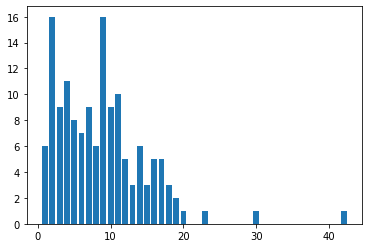

In [19]:
import matplotlib.pyplot as plt

plt.bar(plot_x, plot_y)


### Clasificación de histogramas

Cuando hay más valores de x de los que puede mostrar cómodamente, o cuando su medida de centralidad no es discreta, como en el caso de la centralidad de intermediación, podemos utilizar la "binning." de histogramas. Esto simplemente define una secuencia de intervalos disjuntos llamados *bins* y cuenta el número de valores que caen en cada contenedor. En el caso más simple, podemos simplemente decirle a la función `hist` de Pyplot cuántos contenedores queremos y hará el agrupamiento por nosotros.

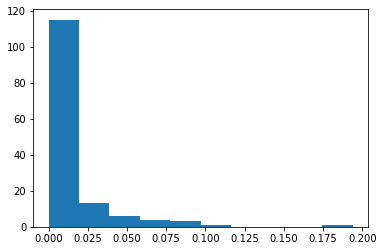

In [20]:
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)


Podemos investigar los `bins` y `counts` devueltos si queremos:

In [21]:
bins

array([0.        , 0.0194006 , 0.03880121, 0.05820181, 0.07760242,
       0.09700302, 0.11640363, 0.13580423, 0.15520483, 0.17460544,
       0.19400604])

In [22]:
counts

array([115.,  13.,   6.,   4.,   3.,   1.,   0.,   0.,   0.,   1.])

De estos, podemos ver que hay 115 valores entre 0 y 0.0194006, 13 valores entre 0.194006 y 0.3880121, etc.

## 3. Prueba de robustez

Otra forma de pensar en la "importancia" relativa de los nodos en una red es medir cuánto dañaría la estructura de la red si se eliminaran nodos en particular. En la vida real, la eliminación de nodos puede ser una persona que se muda y sale de una red social, alguien que cambia de trabajo y es eliminado de una red de correo electrónico, los enrutadores de Internet son atacados/sobrecargados y se caen, etc.

En términos generales, consideramos dos tipos de daños en la red: fallas aleatorias y ataques dirigidos. En una falla aleatoria, los nodos se eligen al azar para su eliminación. En un ataque dirigido, eliminaremos nodos en función de algún criterio, por ejemplo, eliminando nodos en orden decreciente de su grado de centralidad.
### Componentes conectados

Para medir el "damage," mediremos el tamaño del componente conectado más grande de la red, a veces llamado *core*. Primero observamos que `nx.connected_components` es un generador que proporciona los componentes conectados uno a la vez, comenzando con el más grande.



In [23]:
nx.connected_components(G)

<generator object connected_components at 0x000001B126F8D3C0>

Dado que a menudo solo queremos el núcleo, o el componente conectado más grande, podemos usar la función `next` para obtener solo el primer elemento del generador. Cada componente se proporciona como un conjunto de nombres de nodos:

In [24]:
core = next(nx.connected_components(G))
core

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143}


Entonces, el `len` de este conjunto nos da el número de nodos en este componente:

In [25]:
len(core)

143

Si queremos todos los componentes conectados, podemos obtener una lista de ellos:

In [26]:
components = list(nx.connected_components(G))

la longitud de esta lista es el número de componentes conectados:

In [27]:
len(components)

1

### Fallo aleatorio
Cada vez que vamos a participar en un proceso destructivo, queremos hacer una copia del gráfico de la red para atacar, de modo que podamos volver fácilmente al estado original:

In [28]:
C = G.copy()

Para simular una falla aleatoria, elegimos aleatoriamente algunos nombres de nodos y los eliminamos del gráfico. Podemos usar `random.sample` para eliminar más de un nodo a la vez. Tenga en cuenta que necesitamos hacer una `list` de nombres de nodos de los cuales muestrear aleatoriamente:

In [29]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)


La simulación completa funcionará así, a partir de una copia nueva de la red:

1. Mida el tamaño del núcleo de la red en comparación con el tamaño de la red original
2. Seleccione M nodos al azar y elimínelos
3. Repita hasta que haya menos de M nodos

Determinaremos M a partir de cuántos pasos queremos que tome este proceso. Alrededor de 25 pasos deberían ser buenos, así que:

In [30]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
M

5

Luego podemos usar `range` para generar una secuencia del número total de nodos eliminados en cada paso:

In [31]:
num_nodes_removed = range(0, G.number_of_nodes(), M)

El bucle es bastante simple. En cada paso, necesitamos registrar la fracción de nodos restantes en el núcleo.

In [32]:
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

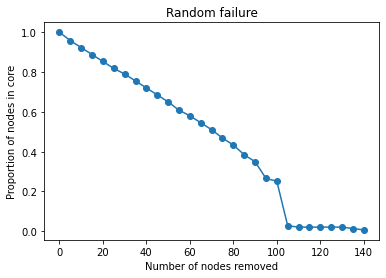

In [33]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')


#### Ataque dirigido

Simular un ataque dirigido es similar, excepto que en lugar de elegir al azar, seleccionaremos los M nodos más centrales en cada paso. Para lograr esto, queremos algo como la función `max` utilizada anteriormente para obtener el nodo más central, pero capaz de obtener los nodos M superiores. Podemos usar la función `sorted` de Python de manera similar a `max` para ordenar primero los nodos por centralidad en orden descendente o inverso. Una vez ordenados por grado, tomamos los primeros M nodos de la lista:

In [34]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]
top_degree_nodes

[105, 17, 95, 48, 132]

Con eso en mente, el ciclo se ve similar. Pongamos todas las piezas juntas aquí:

In [35]:
N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select top M nodes and remove them
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

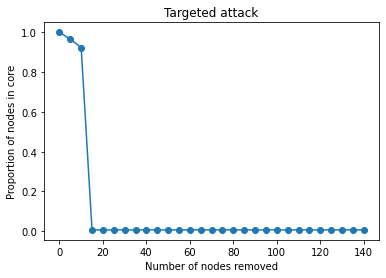

In [36]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')

Como podemos ver, el efecto es dramático. La red se desconecta por completo después de eliminar relativamente pocos nodos centrales en el gráfico.

Pyplot puede trazar estas curvas en el mismo gráfico para un efecto adicional:

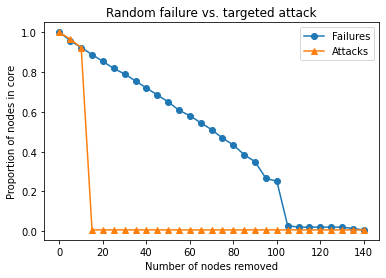

In [37]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()